# Master thesis - Imbalanced learning and model interpretation in credit scoring

620146 Sinan Wang

# Table of Contents

    1. Load Data and artificial dataset construction
       1.1 Load data
       1.2 IR inspection
       1.3 Artificial dataset Construction
    2. Data clean and EDA
       2.1 Numerical feature clean and EDA
       2.2 Categorical features clean and EDA
    3. Splitting data and Feature Engineering
       3.1 Split data
       3.2 Feature engineer
           3.2.1 Standardise numerical variables
           3.2.2 Target encoding categorical variables
    4. Obtain resampling data
    5. Model training
       5.1 Random forest
       5.2 Neural network
       5.3 Logit
           5.3.1 Logit training
           5.3.2 Apply resampling methods on Logit
       5.4 XGBoost
           5.4.1 XGBoost training
           5.4.2 Apply resampling methods on XGBoost
    6. XAI
       6.1 SHAP fearure importance
           6.1.1 Calculate SHAP feature importance
           6.1.2 SHAP rank correlation
           6.1.3 SHAP feature importance visualisation
       6.2 PFI
           6.2.1 Calculate PFI
           6.2.2 PFI rank correlation
           6.2.3 PFI feature importance visualisation

In [1]:
# Inspecting dataport libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import Input,layers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

%load_ext autoreload
%autoreload 2

# 1. Load Data and artificial dataset construction

## 1.1 Load data

In [2]:
#read df
ucid_ori = pd.read_excel("../data/default of credit card clients.xls")

#change column names
ucid_ori.rename(columns={'default': 'target','PAY_0': 'PAY_SEP', 'PAY_2': 'PAY_AUG',
                        'PAY_3': 'PAY_JUL', 'PAY_4': 'PAY_JUN',
                        'PAY_5': 'PAY_MAY', 'PAY_6': 'PAY_APR',
                        'BILL_AMT1': 'BILLAMT_SEP', 'BILL_AMT2': 'BILLAMT_AUG',
                        'BILL_AMT3': 'BILLAMT_JUL', 'BILL_AMT4': 'BILLAMT_JUN',
                        'BILL_AMT5': 'BILLAMT_MAY', 'BILL_AMT6': 'BILLAMT_APR',
                        'PAY_AMT1': 'PAYAMT_SEP', 'PAY_AMT2': 'PAYAMT_AUG',
                        'PAY_AMT3': 'PAYAMT_JUL', 'PAY_AMT4': 'PAYAMT_JUN',
                        'PAY_AMT5': 'PAYAMT_MAY', 'PAY_AMT6': 'PAYAMT_APR'},
                inplace=True)

print(ucid_ori.shape)
print(ucid_ori.info())

(30000, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           30000 non-null  int64
 1   LIMIT_BAL    30000 non-null  int64
 2   SEX          30000 non-null  int64
 3   EDUCATION    30000 non-null  int64
 4   MARRIAGE     30000 non-null  int64
 5   AGE          30000 non-null  int64
 6   PAY_SEP      30000 non-null  int64
 7   PAY_AUG      30000 non-null  int64
 8   PAY_JUL      30000 non-null  int64
 9   PAY_JUN      30000 non-null  int64
 10  PAY_MAY      30000 non-null  int64
 11  PAY_APR      30000 non-null  int64
 12  BILLAMT_SEP  30000 non-null  int64
 13  BILLAMT_AUG  30000 non-null  int64
 14  BILLAMT_JUL  30000 non-null  int64
 15  BILLAMT_JUN  30000 non-null  int64
 16  BILLAMT_MAY  30000 non-null  int64
 17  BILLAMT_APR  30000 non-null  int64
 18  PAYAMT_SEP   30000 non-null  int64
 19  PAYAMT_AUG   30000 non-null  int64

## 1.2 IR inspection

In [3]:
ucid_ori.target.value_counts()

0    23364
1     6636
Name: target, dtype: int64

In [4]:
IR_ori = round(len(ucid_ori.loc[ucid_ori['target'] == 0])/len(ucid_ori.loc[ucid_ori['target'] == 1]),2)
print('The imbalance ratio of the original data set is '+ str(IR_ori))

The imbalance ratio of the original data set is 3.52


<AxesSubplot:ylabel='target'>

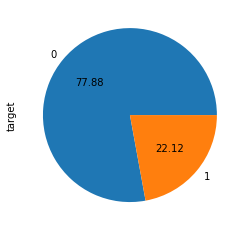

In [5]:
ucid_ori.target.value_counts().plot.pie(autopct = "%.2f")

## 1.3 Artificial dataset Construction

In [6]:
minority = ucid_ori[ucid_ori['target']==1]
majority = ucid_ori[ucid_ori['target']==0]

In [7]:
np.random.seed(10)
remove_n = int(minority.shape[0] - majority.shape[0]/20)
drop_indices = np.random.choice(minority.index, remove_n, replace=False)
minority_art = minority.drop(drop_indices)
print(minority_art.shape) 

(1169, 25)


In [8]:
ucid = pd.concat([majority, minority_art])
IR_art = round(len(ucid.loc[ucid['target'] == 0])/len(ucid.loc[ucid['target'] == 1]),2)

print(ucid.shape)
print(ucid.target.value_counts())
print('The imbalance ratio of artificial data set is '+ str(IR_art))

(24533, 25)
0    23364
1     1169
Name: target, dtype: int64
The imbalance ratio of artificial data set is 19.99


# 2. Data clean and EDA

## 2.1 Numerical feature clean and EDA

In [9]:
#numerical variables 
numvars = ['LIMIT_BAL', 'AGE', 
           'BILLAMT_SEP', 'BILLAMT_AUG', 'BILLAMT_JUL', 
           'BILLAMT_JUN', 'BILLAMT_MAY', 'BILLAMT_APR',
           'PAYAMT_SEP','PAYAMT_AUG', 'PAYAMT_JUL','PAYAMT_JUN','PAYAMT_MAY', 'PAYAMT_APR']
ucid[numvars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24533 entries, 2 to 29991
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   LIMIT_BAL    24533 non-null  int64
 1   AGE          24533 non-null  int64
 2   BILLAMT_SEP  24533 non-null  int64
 3   BILLAMT_AUG  24533 non-null  int64
 4   BILLAMT_JUL  24533 non-null  int64
 5   BILLAMT_JUN  24533 non-null  int64
 6   BILLAMT_MAY  24533 non-null  int64
 7   BILLAMT_APR  24533 non-null  int64
 8   PAYAMT_SEP   24533 non-null  int64
 9   PAYAMT_AUG   24533 non-null  int64
 10  PAYAMT_JUL   24533 non-null  int64
 11  PAYAMT_JUN   24533 non-null  int64
 12  PAYAMT_MAY   24533 non-null  int64
 13  PAYAMT_APR   24533 non-null  int64
dtypes: int64(14)
memory usage: 2.8 MB


### Check the missing values

In [10]:
print(ucid[numvars].isnull().sum() )

LIMIT_BAL      0
AGE            0
BILLAMT_SEP    0
BILLAMT_AUG    0
BILLAMT_JUL    0
BILLAMT_JUN    0
BILLAMT_MAY    0
BILLAMT_APR    0
PAYAMT_SEP     0
PAYAMT_AUG     0
PAYAMT_JUL     0
PAYAMT_JUN     0
PAYAMT_MAY     0
PAYAMT_APR     0
dtype: int64


### EDA

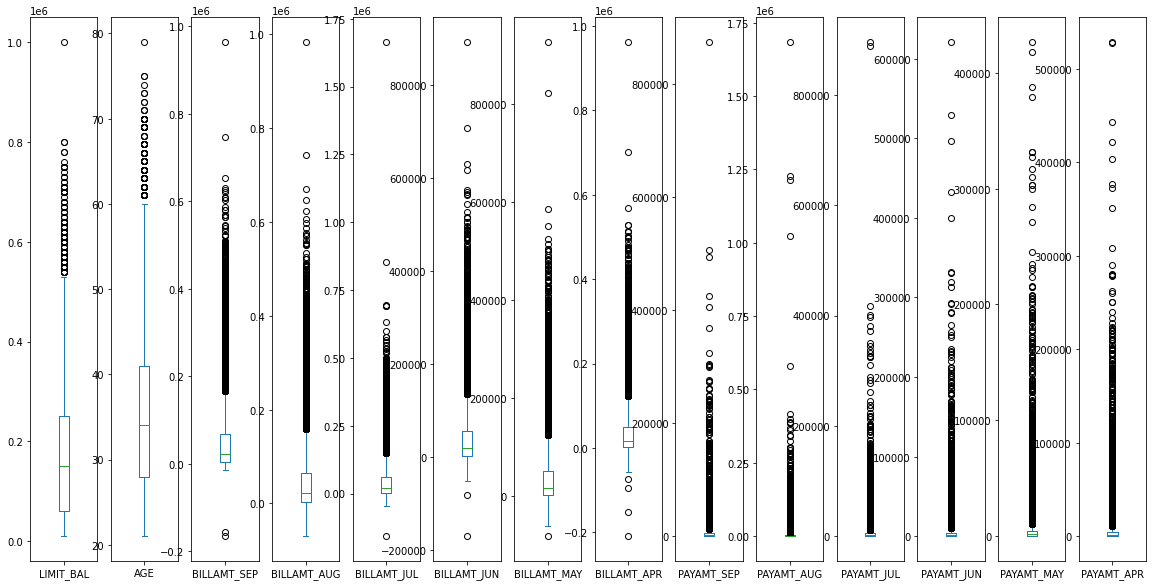

In [11]:
#check the distribution
plt.rcParams["figure.figsize"] = (20,10)
num_vars = ucid[numvars]
num_vars.plot(kind = 'box', subplots=True);
#some outliers- but reasonable

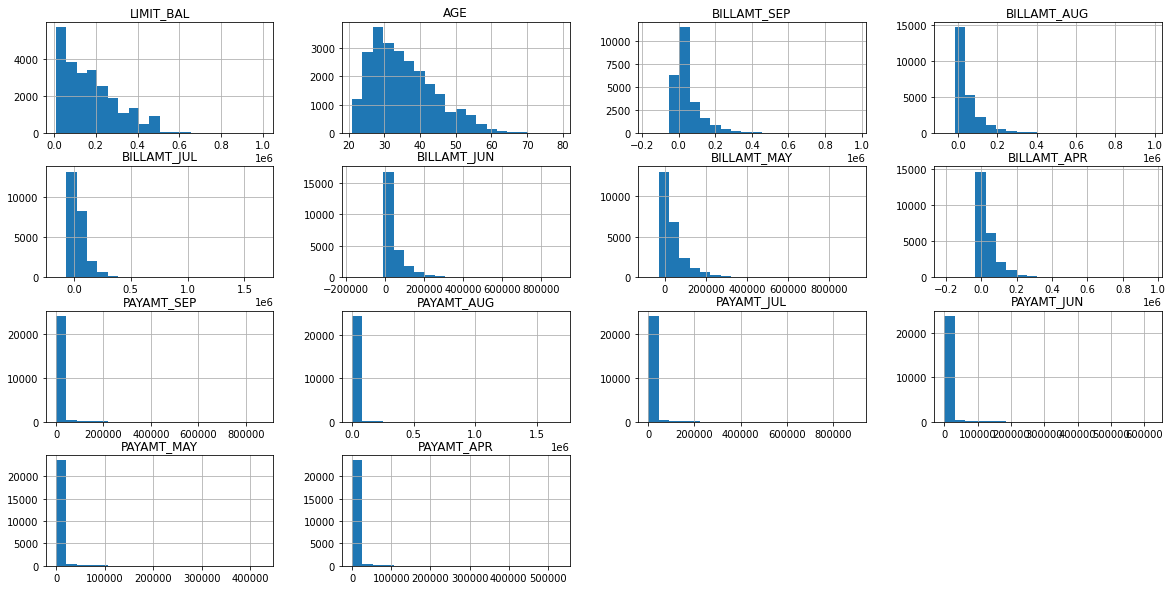

In [12]:
# check the distribution
ucid[numvars].hist(bins=20);

### Check the correlation

In [13]:
all_num = ['LIMIT_BAL', 'AGE', 
           'BILLAMT_SEP', 'BILLAMT_AUG', 'BILLAMT_JUL', 
           'BILLAMT_JUN', 'BILLAMT_MAY', 'BILLAMT_APR',
           'PAYAMT_SEP','PAYAMT_AUG', 'PAYAMT_JUL',
           'PAYAMT_JUN','PAYAMT_MAY', 'PAYAMT_APR', 'target']

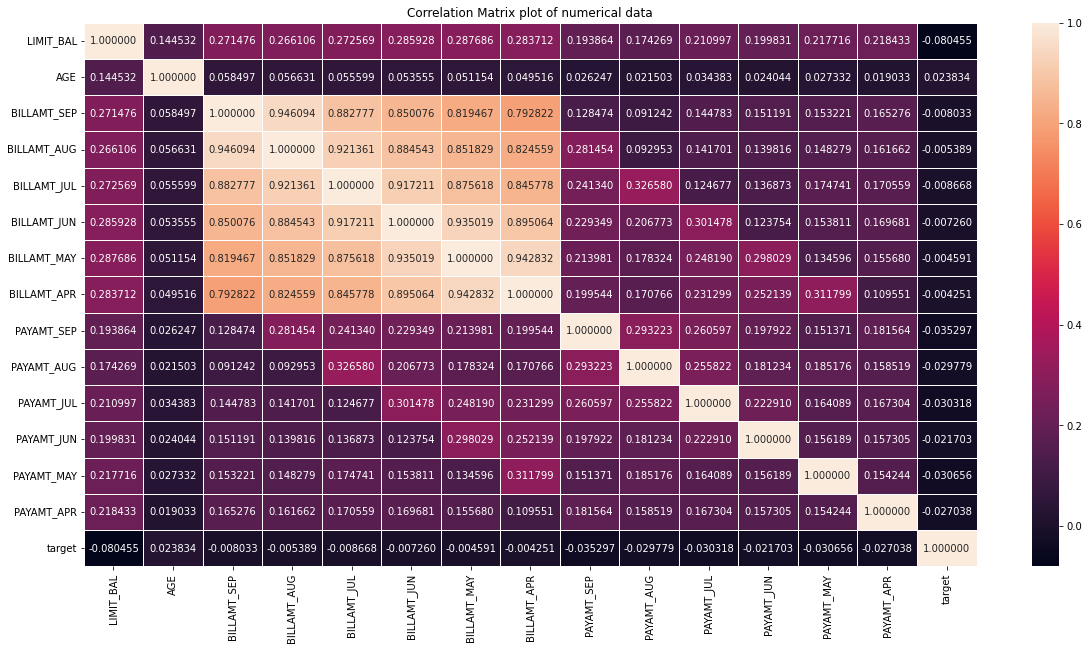

In [14]:
sns.heatmap(ucid[all_num].corr(),annot=True,linewidth=.5,fmt='1f')
plt.title('Correlation Matrix plot of numerical data')
plt.show()

## 2.2 Categorical features clean and EDA

In [15]:
catvars = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_SEP', 'PAY_AUG',
           'PAY_JUL', 'PAY_JUN', 'PAY_MAY', 'PAY_APR']

In [16]:
#change data type
ucid[catvars] = ucid[catvars].astype('category') 

### Check missing value

In [17]:
print(ucid[catvars].isnull().sum())

SEX          0
EDUCATION    0
MARRIAGE     0
PAY_SEP      0
PAY_AUG      0
PAY_JUL      0
PAY_JUN      0
PAY_MAY      0
PAY_APR      0
dtype: int64


### Check categorical levels and disribution

In [18]:
for cat in catvars:
    print(ucid[cat].value_counts())

2    15007
1     9526
Name: SEX, dtype: int64
2    11304
1     8887
3     3901
5      265
4      118
6       44
0       14
Name: EDUCATION, dtype: int64
2    13202
1    11025
3      255
0       51
Name: MARRIAGE, dtype: int64
0     13195
-1     4886
1      2666
-2     2462
2      1132
3       127
4        35
5        13
8         8
6         5
7         4
Name: PAY_SEP, dtype: int64
0     13674
-1     5242
-2     3217
2      2128
3       165
4        55
1        24
5        12
7         9
6         6
8         1
Name: PAY_AUG, dtype: int64
0     13506
-1     5165
-2     3461
2      2202
3       124
4        38
5        13
6        11
7         9
1         3
8         1
Name: PAY_JUL, dtype: int64
0     13965
-1     4924
-2     3664
2      1814
3        89
4        34
5        18
7        18
6         5
1         1
8         1
Name: PAY_JUN, dtype: int64
0     14309
-1     4790
-2     3810
2      1463
3        90
4        42
7        19
5         8
6         2
Name: PAY_MAY, dtype: int6

# 3. Splitting data and Feature Engineering

## 3.1 Splitting data

In [19]:
y = ucid['target']
X = ucid.drop(['target','ID'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.2,shuffle=True, random_state= 1)

## 3.2 Feature engineer

### 3.2.1 Standardise numerical variables

In [20]:
standard = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[numvars] = standard.fit_transform(X_train_scaled[numvars])
X_val_scaled[numvars] = standard.transform(X_val_scaled[numvars])

X_val_scaled[numvars].head()

,LIMIT_BAL,AGE,BILLAMT_SEP,BILLAMT_AUG,BILLAMT_JUL,BILLAMT_JUN,BILLAMT_MAY,BILLAMT_APR,PAYAMT_SEP,PAYAMT_AUG,PAYAMT_JUL,PAYAMT_JUN,PAYAMT_MAY,PAYAMT_APR
28865,1.708443,0.059390,0.241967,0.164931,0.050194,-0.058423,-0.159987,-0.186737,-0.218782,-0.219706,-0.227898,-0.268980,-0.281967,-0.269390
18323,-0.196679,-1.250628,-0.684160,-0.669663,-0.690222,-0.678791,-0.666600,-0.655202,-0.229515,-0.281697,-0.302450,-0.315754,-0.328370,-0.301404
14120,-0.120474,-0.923123,0.479307,0.307028,0.108467,-0.066851,-0.221233,-0.597389,-0.188509,-0.216827,-0.250733,-0.283012,-0.264892,-0.280595
7767,-0.120474,-0.704787,-0.699236,-0.638834,-0.678848,-0.672693,-0.660160,-0.646090,-0.109633,-0.247670,-0.302450,-0.292063,-0.294092,-0.259786
29246,-1.263547,-1.141460,-0.704557,-0.698630,-0.690222,-0.678791,-0.666600,-0.655202,-0.342902,-0.281697,-0.302450,-0.315754,-0.328370,-0.301404


### 3.2.2 Target encoding categorical variables

In [21]:
TE_encoder = TargetEncoder()
X_train_te = TE_encoder.fit_transform(X_train[catvars], y_train)
X_val_te = TE_encoder.transform(X_val[catvars])
print(X_train_te.shape)

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


(19626, 9)


In [22]:
#CONCAT
X_train_final = pd.concat([X_train_scaled[numvars],X_train_te], axis=1)
X_val_final = pd.concat([X_val_scaled[numvars],X_val_te], axis=1)

# 4. Obtain resampling data

In [23]:
def resampling(ratio=1):
    X_data_list = []
    y_data_list = []
    for single_class in classes:
        if single_class == NearMiss:
            instance = single_class(sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))  
        else:
            instance = single_class(random_state=40, sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))       
    return X_data_list, y_data_list

In [24]:
classes = [RandomOverSampler, SMOTE, BorderlineSMOTE,
           RandomUnderSampler, NearMiss, InstanceHardnessThreshold,
           SMOTEENN, SMOTETomek]

#IR=1
X_data_list1, y_data_list1 = resampling(1)

print(len(X_data_list1),len(y_data_list1))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 1 completed
Resampled dataset shape Counter({0: 18676, 1: 18676})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 1 completed
Resampled dataset shape Counter({0: 18676, 1: 18676})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 1 completed
Resampled dataset shape Counter({0: 18676, 1: 18676})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 1 completed
Resampled dataset shape Counter({0: 950, 1: 950})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 1 completed
Resampled dataset shape Counter({0: 950, 1: 950})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 1 completed
Resampled dataset shape Counter({0: 3721, 1: 950})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 1 completed
Resampled dataset shape Counter({1: 18024, 0: 13750})
<

In [25]:
#IR=5
X_data_list2, y_data_list2 = resampling(0.2)

print(len(X_data_list2),len(y_data_list2))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 18676, 1: 3735})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 18676, 1: 3735})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 18676, 1: 3735})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 4750, 1: 950})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.2 completed
Resampled dataset shape Counter({0: 4750, 1: 950})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.2 completed
Resampled dataset shape Counter({0: 6765, 1: 950})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.2 completed
Resampled dataset shape Counter({0: 15294,

In [26]:
#IR=10
X_data_list3, y_data_list3 = resampling(0.1)

print(len(X_data_list3),len(y_data_list3))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 18676, 1: 1867})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 18676, 1: 1867})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 18676, 1: 1867})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 9500, 1: 950})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.1 completed
Resampled dataset shape Counter({0: 9500, 1: 950})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.1 completed
Resampled dataset shape Counter({0: 10987, 1: 950})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.1 completed
Resampled dataset shape Counter({0: 16022

In [27]:
#IR=15
X_data_list4, y_data_list4 = resampling(0.0667)

print(len(X_data_list4),len(y_data_list4))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 18676, 1: 1245})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 18676, 1: 1245})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 18676, 1: 1245})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 14242, 1: 950})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.0667 completed
Resampled dataset shape Counter({0: 14242, 1: 950})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.0667 completed
Resampled dataset shape Counter({0: 14397, 1: 950})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.0667 completed
Resampled dataset 

# 5. Model training

## 5.1 Random forest

In [28]:
#grid search for hyper parameter tuning
rf = RandomForestClassifier(random_state=0)                       

param_grid = {'n_estimators': [25, 50, 100],
              'max_features': [2, 4, 8]
              }

gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=0)
gs_rf.fit(X_train_final, y_train.values.ravel())     
rf_tune = gs_rf.best_estimator_
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)
print(rf_tune)

Best CV AUC: 0.7433
Optimal RF meta-parameters:
{'max_features': 4, 'n_estimators': 100}
RandomForestClassifier(max_features=4, random_state=0)


In [23]:
#run this to skip hyper parameter tuning
rf_tune=RandomForestClassifier(random_state=0, max_features = 4, n_estimators =100)
rf_tune.fit(X_train_final, y_train.values.ravel())

RandomForestClassifier(max_features=4, random_state=0)

In [24]:
from function import evaluation
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,rf_tune)
rf_eva = ['RF', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
rf_eva

['RF', 1.0, 0.715, 0.375, 0.041, 0.202, 0.074]

## 5.2  neural network

In [25]:
# Define model
model = keras.Sequential([ 
    keras.Input(shape=(X_train_final.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation = "sigmoid")
])

# Compile model
model.compile(optimizer = 'adam',
    loss="binary_crossentropy",
    metrics = ["AUC"]
)
print(model.summary())

early_stopping_monitor = EarlyStopping(
    monitor='val_auc',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                384       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
None


2023-07-14 16:42:00.187229: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# Fit the model
history = model.fit(X_train_final,
                    y_train,
                    epochs = 20,
                    batch_size = 2,
                    validation_data=(X_val_final, y_val),
                    callbacks=[early_stopping_monitor])

Epoch 1/20
9813/9813 [==============================] - 10s 929us/step - loss: 0.1983 - auc: 0.6366 - val_loss: 0.1675 - val_auc: 0.7066
Epoch 2/20
9813/9813 [==============================] - 9s 884us/step - loss: 0.1710 - auc: 0.7501 - val_loss: 0.1633 - val_auc: 0.7356
Epoch 3/20
9813/9813 [==============================] - 9s 883us/step - loss: 0.1678 - auc: 0.7645 - val_loss: 0.1620 - val_auc: 0.7407
Epoch 4/20
9813/9813 [==============================] - 8s 853us/step - loss: 0.1665 - auc: 0.7696 - val_loss: 0.1658 - val_auc: 0.7387
Epoch 5/20
9813/9813 [==============================] - 9s 881us/step - loss: 0.1657 - auc: 0.7725 - val_loss: 0.1626 - val_auc: 0.7425
Epoch 6/20
9813/9813 [==============================] - 9s 904us/step - loss: 0.1650 - auc: 0.7725 - val_loss: 0.1648 - val_auc: 0.7310
Epoch 7/20
9813/9813 [==============================] - 9s 907us/step - loss: 0.1656 - auc: 0.7757 - val_loss: 0.1636 - val_auc: 0.7355
Epoch 8/20
9813/9813 [=========================

In [27]:
from function import evaluation_nn
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation_nn(y_train,X_train_final,y_val,X_val_final,model)
nn_eva = ['NN', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
nn_eva

['NN', 0.786, 0.744, 0.333, 0.018, 0.135, 0.035]

## 5.3 Logit

In [28]:
logit = LogisticRegressionCV(cv=5, random_state=0, max_iter=2000).fit(X_train_final,y_train.values.ravel())

In [29]:
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,logit)
logit_eva = ['logit', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
logit_eva

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


['logit', 0.652, 0.672, 0.0, 0.0, 0.0, 0.0]

### 5.3.2 Applying resampling methods on logit

In [36]:
def logit_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_lr = logit.fit(X_data, y_data)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,instance_lr)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [37]:
#IR =1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog = pd.DataFrame(dic)
dflog.loc[len(dflog)] = logit_eva
dflog

AUC validation:[0.757, 0.751, 0.738, 0.75, 0.477, 0.763, 0.754, 0.751]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.780,0.757,0.136,0.511,0.659,0.215
1,SMOTE,0.805,0.751,0.135,0.530,0.668,0.216
2,BorderlineSMOTE,0.861,0.738,0.132,0.502,0.652,0.209
3,RandomUnderSampler,0.767,0.750,0.114,0.575,0.674,0.190
4,NearMiss,0.935,0.477,0.046,0.872,0.376,0.088
5,InstanceHardnessThreshold,0.899,0.763,0.131,0.598,0.698,0.215
6,SMOTEENN,0.840,0.754,0.101,0.648,0.688,0.174
7,SMOTETomek,0.806,0.751,0.136,0.530,0.668,0.216
8,logit,0.652,0.672,0.000,0.000,0.000,0.000


In [38]:
#IR = 5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog2 = pd.DataFrame(dic)
dflog2.loc[len(dflog2)] = logit_eva
dflog2

AUC validation:[0.753, 0.753, 0.745, 0.754, 0.494, 0.762, 0.75, 0.752]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.780,0.753,0.276,0.283,0.523,0.279
1,SMOTE,0.797,0.753,0.273,0.269,0.510,0.271
2,BorderlineSMOTE,0.842,0.745,0.262,0.311,0.546,0.284
3,RandomUnderSampler,0.781,0.754,0.275,0.292,0.531,0.283
4,NearMiss,0.841,0.494,0.045,0.516,0.503,0.083
5,InstanceHardnessThreshold,0.887,0.762,0.154,0.539,0.681,0.239
6,SMOTEENN,0.848,0.750,0.250,0.320,0.553,0.281
7,SMOTETomek,0.800,0.752,0.276,0.269,0.510,0.273
8,logit,0.652,0.672,0.000,0.000,0.000,0.000


In [39]:
#IR =10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog3 = pd.DataFrame(dic)
dflog3.loc[len(dflog3)] = logit_eva
dflog3

AUC validation:[0.752, 0.752, 0.747, 0.75, 0.561, 0.764, 0.733, 0.753]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.777,0.752,0.276,0.110,0.329,0.157
1,SMOTE,0.787,0.752,0.284,0.114,0.336,0.163
2,BorderlineSMOTE,0.822,0.747,0.275,0.164,0.401,0.206
3,RandomUnderSampler,0.780,0.750,0.274,0.142,0.373,0.187
4,NearMiss,0.757,0.561,0.052,0.224,0.426,0.085
5,InstanceHardnessThreshold,0.864,0.764,0.179,0.429,0.624,0.253
6,SMOTEENN,0.875,0.733,0.301,0.114,0.336,0.166
7,SMOTETomek,0.801,0.753,0.272,0.128,0.355,0.174
8,logit,0.652,0.672,0.000,0.000,0.000,0.000


In [40]:
#IR =15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog4 = pd.DataFrame(dic)
dflog4.loc[len(dflog4)] = logit_eva
dflog4

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


AUC validation:[0.675, 0.675, 0.743, 0.755, 0.663, 0.762, 0.711, 0.678]


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.654,0.675,0.000,0.000,0.000,0.000
1,SMOTE,0.654,0.675,0.000,0.000,0.000,0.000
2,BorderlineSMOTE,0.776,0.743,1.000,0.014,0.117,0.027
3,RandomUnderSampler,0.776,0.755,0.444,0.055,0.234,0.098
4,NearMiss,0.714,0.663,0.020,0.005,0.067,0.007
5,InstanceHardnessThreshold,0.842,0.762,0.216,0.402,0.612,0.281
6,SMOTEENN,0.956,0.711,0.368,0.032,0.179,0.059
7,SMOTETomek,0.670,0.678,0.000,0.000,0.000,0.000
8,logit,0.652,0.672,0.000,0.000,0.000,0.000


### Aggregate and output result

In [41]:
#aggregate AUC validation
dflogit = pd.concat([dflog4.iloc[:,2],dflog3.iloc[:,2],dflog2.iloc[:,2],dflog.iloc[:,2]],axis=1)
dflogit.columns = ['1:15', '1:10', '1:5', '1:1']
dflogit.index = dflog4.iloc[:,0]
dflogit

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.675,0.752,0.753,0.757
SMOTE,0.675,0.752,0.753,0.751
BorderlineSMOTE,0.743,0.747,0.745,0.738
RandomUnderSampler,0.755,0.750,0.754,0.750
NearMiss,0.663,0.561,0.494,0.477
InstanceHardnessThreshold,0.762,0.764,0.762,0.763
SMOTEENN,0.711,0.733,0.750,0.754
SMOTETomek,0.678,0.753,0.752,0.751
logit,0.672,0.672,0.672,0.672


In [35]:
import os
path = './result'
file_path = path + '/ucid_logit_auc.csv'
os.makedirs(path, exist_ok=True)
dflogit.to_csv(file_path, index =True, encoding = 'utf-8-sig') 

In [43]:
#aggregate gmeans
logit_gmeans = pd.concat([dflog4.iloc[:,5],dflog3.iloc[:,5],dflog2.iloc[:,5],dflog.iloc[:,5]],axis=1)
logit_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
logit_gmeans.index = dflog4.iloc[:,0]
logit_gmeans

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.000,0.329,0.523,0.659
SMOTE,0.000,0.336,0.510,0.668
BorderlineSMOTE,0.117,0.401,0.546,0.652
RandomUnderSampler,0.234,0.373,0.531,0.674
NearMiss,0.067,0.426,0.503,0.376
InstanceHardnessThreshold,0.612,0.624,0.681,0.698
SMOTEENN,0.179,0.336,0.553,0.688
SMOTETomek,0.000,0.355,0.510,0.668
logit,0.000,0.000,0.000,0.000


In [44]:
logit_gmeans.to_csv(path + '/ucid_logit_gmeans.csv', index =True, encoding = 'utf-8-sig') 

In [45]:
#aggregate fmeasure
logit_fmeasure = pd.concat([dflog4.iloc[:,6],dflog3.iloc[:,6],dflog2.iloc[:,6],dflog.iloc[:,6]],axis=1)
logit_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
logit_fmeasure.index = dflog4.iloc[:,0]
logit_fmeasure

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.000,0.157,0.279,0.215
SMOTE,0.000,0.163,0.271,0.216
BorderlineSMOTE,0.027,0.206,0.284,0.209
RandomUnderSampler,0.098,0.187,0.283,0.190
NearMiss,0.007,0.085,0.083,0.088
InstanceHardnessThreshold,0.281,0.253,0.239,0.215
SMOTEENN,0.059,0.166,0.281,0.174
SMOTETomek,0.000,0.174,0.273,0.216
logit,0.000,0.000,0.000,0.000


In [46]:
logit_fmeasure.to_csv(path + '/ucid_logit_fmeasure.csv', index =True, encoding = 'utf-8-sig') 

## 5.4 XGBoost

### 5.4.1 training XGBoost

In [47]:
#perform hyper parameter grid search
xgb_param_grid = {
    'colsample_bytree': np.linspace(0.1, 0.8, 3), # Subsample ratio of columns when constructing each tree
    'n_estimators': [50,75,100],  # Number of gradient boosted trees
    'max_depth': [3, 5, 8],   # max depth of decision trees
    'learning_rate': np.linspace(0.01, 0.1, 3), #Boosting learning rate
    'subsample': np.linspace(0.5, 0.8, 3)}  # Subsample ratio of the training instance

gs_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric ='auc'), 
                      param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=0)

gs_xgb.fit(X_train_final, y_train.values.ravel())
xgb_tune = gs_xgb.best_estimator_
print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)
print(xgb_tune)

Best CV AUC: 0.7846
Optimal XGB meta-parameters:
{'colsample_bytree': 0.45000000000000007, 'learning_rate': 0.05500000000000001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45000000000000007,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05500000000000001, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [30]:
#run this to skip xgb tuning
xgb_tune = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45000000000000007,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05500000000000001, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

xgb_tune.fit(X_train_final, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45000000000000007,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05500000000000001, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [31]:
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,xgb_tune)
xgb_eva=['xgb', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
xgb_eva

['xgb', 0.873, 0.748, 0.333, 0.027, 0.165, 0.051]

### 5.4.2 Apply resampling methods on  XGBoost

In [56]:
def xgb_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = xgb_tune.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,xgb_tune)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
       
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [ ]:
#IR =1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb = pd.DataFrame(dic)
dfxgb.loc[len(dfxgb)] = xgb_eva
dfxgb

In [ ]:
#IR =5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb2 = pd.DataFrame(dic)
dfxgb2.loc[len(dfxgb2)] = xgb_eva
dfxgb2

In [ ]:
#IR =10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb3 = pd.DataFrame(dic)
dfxgb3.loc[len(dfxgb3)] = xgb_eva
dfxgb3

In [ ]:
#IR =15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb4 = pd.DataFrame(dic)
dfxgb4.loc[len(dfxgb4)] = xgb_eva
dfxgb4

### Aggregate and output results

In [61]:
#aggregate AUC validation
dfxgboost = pd.concat([dfxgb4.iloc[:,2],dfxgb3.iloc[:,2],dfxgb2.iloc[:,2],dfxgb.iloc[:,2]],axis=1)
dfxgboost.columns = ['1:15', '1:10', '1:5', '1:1']
dfxgboost.index = dfxgb4.iloc[:,0]
dfxgboost

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.762,0.752,0.757,0.746
SMOTE,0.760,0.754,0.745,0.748
BorderlineSMOTE,0.752,0.748,0.758,0.744
RandomUnderSampler,0.755,0.754,0.756,0.743
NearMiss,0.688,0.586,0.500,0.532
InstanceHardnessThreshold,0.758,0.757,0.748,0.745
SMOTEENN,0.739,0.748,0.749,0.738
SMOTETomek,0.756,0.751,0.749,0.743
xgb,0.748,0.748,0.748,0.748


In [62]:
dfxgboost.to_csv(path + '/ucid_xgb_auc.csv', index = True, encoding = 'utf-8-sig') 

In [63]:
#aggregate gmeans
xgb_gmeans = pd.concat([dfxgb4.iloc[:,5],dfxgb3.iloc[:,5],dfxgb2.iloc[:,5],dfxgb.iloc[:,5]],axis=1)
xgb_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_gmeans.index = dfxgb4.iloc[:,0]
xgb_gmeans

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.096,0.213,0.395,0.671
SMOTE,0.068,0.000,0.277,0.505
BorderlineSMOTE,0.166,0.117,0.322,0.555
RandomUnderSampler,0.191,0.269,0.513,0.687
NearMiss,0.247,0.348,0.486,0.438
InstanceHardnessThreshold,0.612,0.610,0.661,0.693
SMOTEENN,0.000,0.151,0.401,0.565
SMOTETomek,0.096,0.191,0.293,0.475
xgb,0.165,0.165,0.165,0.165


In [64]:
xgb_gmeans.to_csv(path + '/ucid_xgb_gmeans.csv', index = True, encoding = 'utf-8-sig') 

In [65]:
#aggregate fmeasure
xgb_fmeasure = pd.concat([dfxgb4.iloc[:,6],dfxgb3.iloc[:,6],dfxgb2.iloc[:,6],dfxgb.iloc[:,6]],axis=1)
xgb_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_fmeasure.index = dfxgb4.iloc[:,0]
xgb_fmeasure

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.018,0.082,0.198,0.182
SMOTE,0.009,0.000,0.124,0.254
BorderlineSMOTE,0.053,0.027,0.152,0.273
RandomUnderSampler,0.066,0.119,0.260,0.177
NearMiss,0.064,0.066,0.078,0.092
InstanceHardnessThreshold,0.283,0.269,0.234,0.188
SMOTEENN,0.000,0.043,0.206,0.271
SMOTETomek,0.018,0.066,0.137,0.248
xgb,0.051,0.051,0.051,0.051


In [66]:
xgb_fmeasure.to_csv(path + '/ucid_xgb_fmeasure.csv', index = True, encoding = 'utf-8-sig') 

In [32]:
#aggregate the evaluation results for four models
models = [logit_eva[0], rf_eva[0],xgb_eva[0],nn_eva[0]]
AUC_val = [logit_eva[2], rf_eva[2],xgb_eva[2],nn_eva[2]]
Gmeans = [logit_eva[5], rf_eva[5],xgb_eva[5],nn_eva[5]]
Fmeasure = [logit_eva[6], rf_eva[6],xgb_eva[6],nn_eva[6]]
dic ={'Model': models, 'AUC_validation':AUC_val, 'G-means':Gmeans, 'F1-score':Fmeasure}
models_eva = pd.DataFrame(dic)
models_eva

,Model,AUC_validation,G-means,F1-score
0,logit,0.672,0.000,0.000
1,RF,0.715,0.202,0.074
2,xgb,0.748,0.165,0.051
3,NN,0.744,0.135,0.035


In [36]:
models_eva.to_csv(path + '/ucid_models.csv', index = True, encoding = 'utf-8-sig') 

# 6. XAI

## 6.1 SHAP fearure importance

### 6.1.1 Calculate SHAP feature importance

In [69]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
explainer_xgb = shap.TreeExplainer(xgb_tune, data=X_train_final, 
                                   feature_perturbation='interventional', model_output='probability')
shap_values_xgb = explainer_xgb.shap_values(X_train_final)
print(shap_values_xgb.shape)

result__ = pd.DataFrame(shap_values_xgb, columns = X_train_final.columns)

#for global importance, we average the absolute Shapley values per feature across the data: 
vals__ = np.abs(result__.values).mean(0).round(3)
shap_importance = pd.DataFrame(list(zip(X_train_final.columns, vals__)),
                                  columns=['feature','xgb'])
print(shap_importance.head())

 98%|===================| 19330/19626 [00:49<00:00]        

(19626, 23)
       feature    xgb
0    LIMIT_BAL  0.004
1          AGE  0.002
2  BILLAMT_SEP  0.004
3  BILLAMT_AUG  0.002
4  BILLAMT_JUL  0.002


In [70]:
def shap_generator(X_data_list, y_data_list,model):
    vals_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,
                                 eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        explainer_instance = shap.TreeExplainer(model, data=X_data, 
                                                feature_perturbation='interventional', model_output='probability')
        shap_values_instance = explainer_instance.shap_values(X_data)
        result = pd.DataFrame(shap_values_instance, columns = X_data.columns)
        vals = np.abs(result.values).mean(0).round(3)
        
        vals_list.append(vals)
    return vals_list

In [71]:
#extract RUS,IHT resampled data sets
#order: rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15

RE_Xlist= [X_data_list1[3],X_data_list2[3],X_data_list3[3], X_data_list4[3],
           X_data_list1[4],X_data_list2[4], X_data_list3[4], X_data_list4[4]]
RE_ylist =[y_data_list1[3],y_data_list2[3],y_data_list3[3], y_data_list4[3],
           y_data_list1[4],y_data_list2[4], y_data_list3[4], y_data_list4[4]]

In [ ]:
shap_list = shap_generator(RE_Xlist, RE_ylist,xgb_tune)

In [73]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
shap_importance['rus1'] = shap_list[0]
shap_importance['rus5'] = shap_list[1]
shap_importance['rus10'] = shap_list[2]
shap_importance['rus15'] = shap_list[3]
shap_importance['iht1'] = shap_list[4]
shap_importance['iht5'] = shap_list[5]
shap_importance['iht10'] = shap_list[6]
shap_importance['iht15'] = shap_list[7]

shap_importance

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,LIMIT_BAL,0.004,0.024,0.015,0.003,0.004,0.000,0.005,0.001,0.002
1,AGE,0.002,0.009,0.011,0.002,0.002,0.006,0.007,0.001,0.002
2,BILLAMT_SEP,0.004,0.010,0.015,0.003,0.003,0.006,0.018,0.008,0.004
3,BILLAMT_AUG,0.002,0.007,0.007,0.002,0.002,0.011,0.012,0.003,0.002
4,BILLAMT_JUL,0.002,0.005,0.006,0.001,0.001,0.011,0.007,0.000,0.001
5,BILLAMT_JUN,0.001,0.007,0.007,0.001,0.002,0.005,0.005,0.001,0.001
6,BILLAMT_MAY,0.001,0.005,0.003,0.001,0.001,0.004,0.001,0.000,0.002
7,BILLAMT_APR,0.001,0.009,0.004,0.001,0.001,0.018,0.003,0.000,0.001
8,PAYAMT_SEP,0.003,0.016,0.013,0.004,0.005,0.003,0.007,0.001,0.003
9,PAYAMT_AUG,0.002,0.012,0.008,0.001,0.003,0.003,0.004,0.000,0.002


In [74]:
shap_importance.to_csv(path + '/shap_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.1.2  SHAP rank correlation

In [75]:
rank_shap = shap_importance.corr(method = 'spearman').round(3)
print(rank_shap)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.844  0.832  0.835  0.806 -0.063  0.686  0.731  0.880
rus1   0.844  1.000  0.881  0.795  0.893 -0.034  0.443  0.533  0.795
rus5   0.832  0.881  1.000  0.803  0.851  0.056  0.601  0.619  0.763
rus10  0.835  0.795  0.803  1.000  0.913 -0.053  0.596  0.781  0.892
rus15  0.806  0.893  0.851  0.913  1.000 -0.106  0.528  0.691  0.868
iht1  -0.063 -0.034  0.056 -0.053 -0.106  1.000  0.336 -0.048 -0.046
iht5   0.686  0.443  0.601  0.596  0.528  0.336  1.000  0.795  0.673
iht10  0.731  0.533  0.619  0.781  0.691 -0.048  0.795  1.000  0.814
iht15  0.880  0.795  0.763  0.892  0.868 -0.046  0.673  0.814  1.000


In [76]:
rank_shap.to_csv(path + '/rank_shap.csv', index = True, encoding = 'utf-8-sig') 

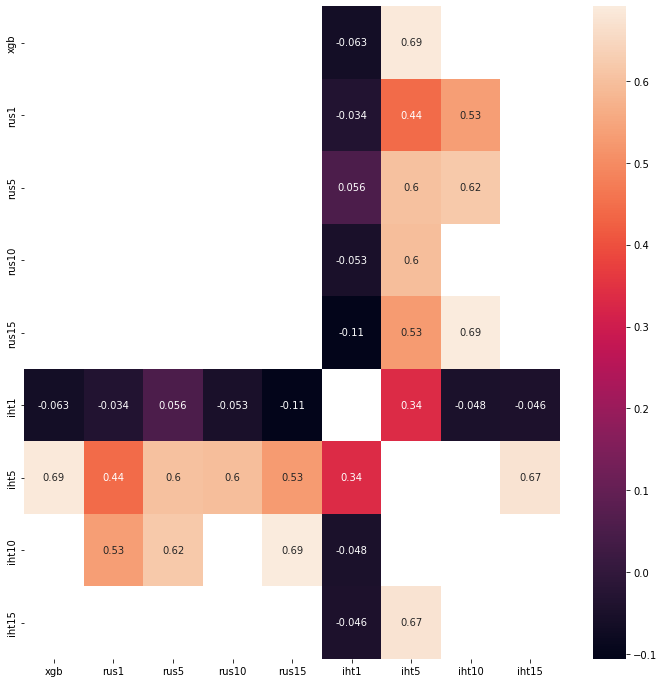

In [77]:
f,ax = plt.subplots(figsize=(12, 12))
snsfilter = sns.heatmap(shap_importance.corr(method = 'spearman')[(shap_importance.corr(method = 'spearman') <= 0.692)],
            annot=True);

### 6.1.3  SHAP feature importance visualisation

In [78]:
#select top 10 features for original xgb
shap_top10 = shap_importance.sort_values(['xgb'], ascending=[False])
shap_top10 = shap_top10.head(10)
shap_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
17,PAY_SEP,0.016,0.040,0.044,0.014,0.020,0.000,0.026,0.010,0.018
18,PAY_AUG,0.006,0.038,0.015,0.010,0.007,0.012,0.018,0.008,0.008
0,LIMIT_BAL,0.004,0.024,0.015,0.003,0.004,0.000,0.005,0.001,0.002
10,PAYAMT_JUL,0.004,0.033,0.015,0.006,0.005,0.001,0.003,0.001,0.003
20,PAY_JUN,0.004,0.012,0.010,0.003,0.004,0.001,0.008,0.002,0.005
11,PAYAMT_JUN,0.004,0.017,0.013,0.005,0.004,0.000,0.005,0.002,0.004
2,BILLAMT_SEP,0.004,0.010,0.015,0.003,0.003,0.006,0.018,0.008,0.004
22,PAY_APR,0.003,0.009,0.005,0.004,0.004,0.002,0.007,0.003,0.003
8,PAYAMT_SEP,0.003,0.016,0.013,0.004,0.005,0.003,0.007,0.001,0.003
21,PAY_MAY,0.003,0.008,0.007,0.006,0.003,0.000,0.007,0.005,0.003


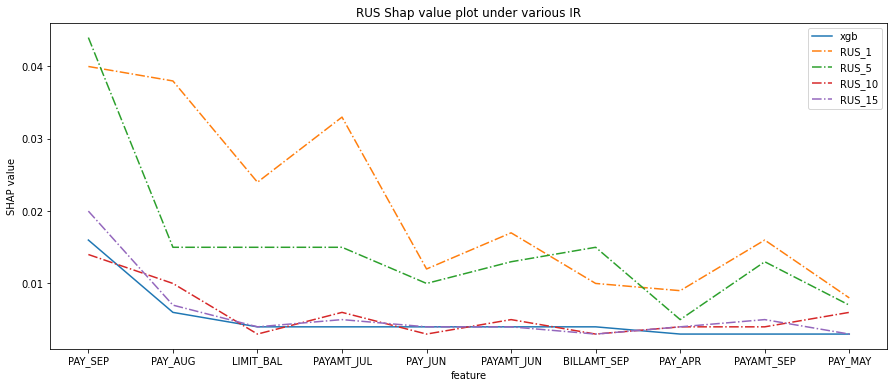

In [79]:
#1.aggeragate by approaches
#rus under different IR
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
rus_1 =shap_top10['rus1'].tolist()
rus_5 =shap_top10['rus5'].tolist()
rus_10 =shap_top10['rus10'].tolist()
rus_15 =shap_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('RUS Shap value plot under various IR')
plt.show()

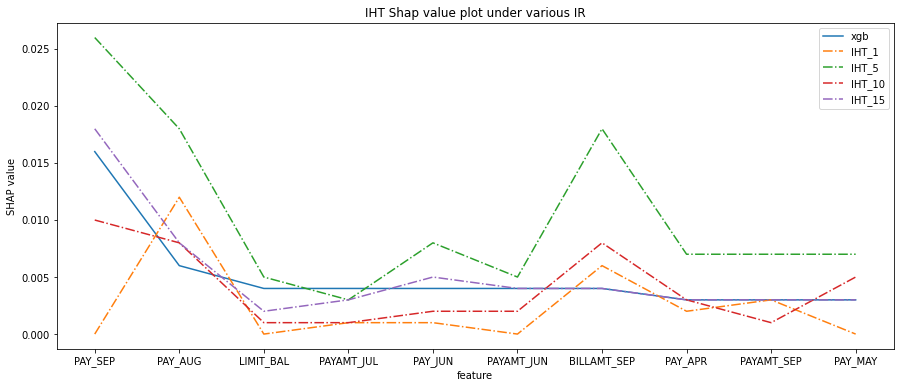

In [80]:
#iht under different IR
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
iht_1 =shap_top10['iht1'].tolist()
iht_5 =shap_top10['iht5'].tolist()
iht_10 =shap_top10['iht10'].tolist()
iht_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('IHT Shap value plot under various IR')
plt.show()

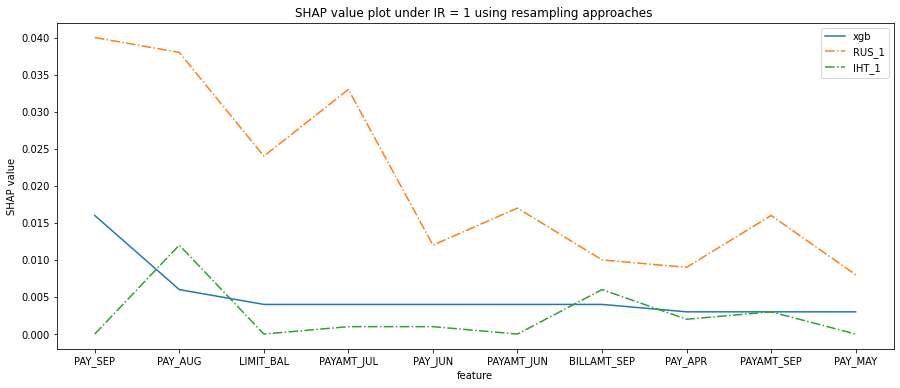

In [81]:
#aggeragate by ratio
#IR=1 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_1 =shap_top10['rus1'].tolist()
IHT_1 =shap_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 1 using resampling approaches ')
plt.show()

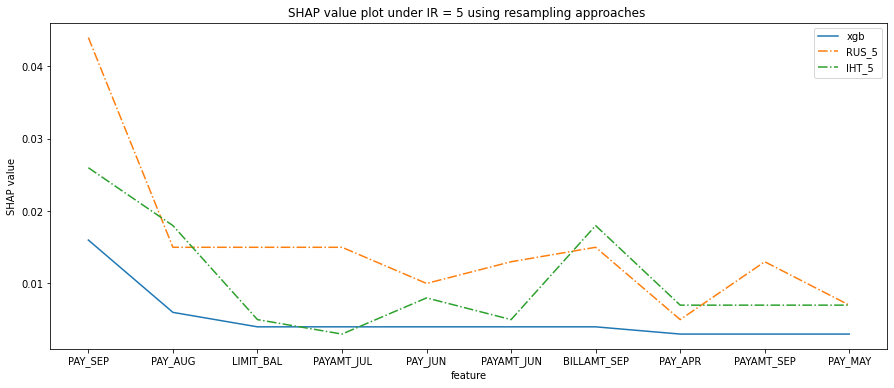

In [82]:
#IR=5 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_5 =shap_top10['rus5'].tolist()
IHT_5 =shap_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 5 using resampling approaches ')
plt.show()

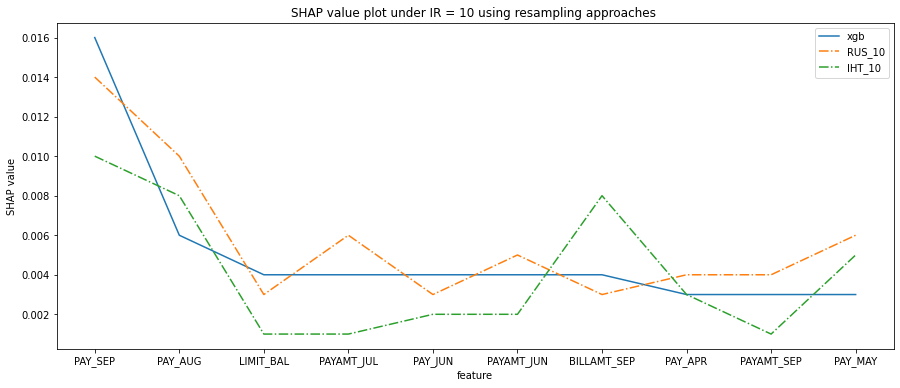

In [83]:
#IR=10 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_10 =shap_top10['rus10'].tolist()
IHT_10 =shap_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 10 using resampling approaches ')
plt.show()

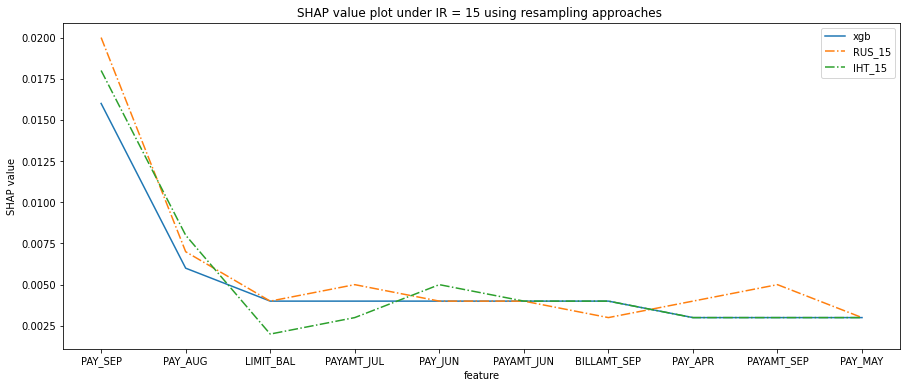

In [84]:
#IR=15 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_15 =shap_top10['rus15'].tolist()
IHT_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 15 using resampling approaches ')
plt.show()

## 6.2 PFI

### 6.2.1 Calculate PFI

In [85]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
pfi_xgb = permutation_importance(xgb_tune, X_train_final, y_train, scoring='roc_auc', n_repeats=5, random_state=1)
pfi_importance = pd.concat([pd.DataFrame(X_train_final.columns),pd.DataFrame(pfi_xgb.importances_mean.round(3))],axis = 1)
pfi_importance = pfi_importance.set_axis(['feature','xgb'], axis='columns')
pfi_importance.head()

,feature,xgb
0,LIMIT_BAL,0.015
1,AGE,0.006
2,BILLAMT_SEP,0.016
3,BILLAMT_AUG,0.011
4,BILLAMT_JUL,0.009


In [86]:
def pfi_generator(X_data_list, y_data_list, model):
    pfi_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        pfi_xgb = permutation_importance(model, X_data, y_data, scoring='roc_auc', n_repeats=5, random_state=1)
        pfi_value = pfi_xgb.importances_mean.round(3) 
        pfi_list.append(pfi_value)
    return pfi_list

In [ ]:
pfi_list = pfi_generator(RE_Xlist, RE_ylist,xgb_tune)

In [88]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
pfi_importance['rus1'] = pfi_list[0]
pfi_importance['rus5'] = pfi_list[1]
pfi_importance['rus10'] = pfi_list[2]
pfi_importance['rus15'] = pfi_list[3]
pfi_importance['iht1'] = pfi_list[4]
pfi_importance['iht5'] = pfi_list[5]
pfi_importance['iht10'] = pfi_list[6]
pfi_importance['iht15'] = pfi_list[7]

pfi_importance.head()

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,LIMIT_BAL,0.015,0.024,0.021,0.009,0.013,0.000,0.005,0.001,0.006
1,AGE,0.006,0.012,0.017,0.006,0.007,0.030,0.014,0.003,0.013
2,BILLAMT_SEP,0.016,0.010,0.021,0.011,0.009,0.010,0.015,0.011,0.015
3,BILLAMT_AUG,0.011,0.012,0.011,0.005,0.009,0.014,0.008,0.004,0.008
4,BILLAMT_JUL,0.009,0.005,0.012,0.006,0.010,0.033,0.005,0.000,0.006


In [89]:
pfi_importance.to_csv(path + '/pfi_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.2.2 PFI rank correlation

In [90]:
rank_pfi = pfi_importance.corr(method = 'spearman').round(3)
print(rank_pfi)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.793  0.895  0.511  0.841  0.251  0.710  0.321  0.704
rus1   0.793  1.000  0.793  0.632  0.762  0.245  0.717  0.431  0.690
rus5   0.895  0.793  1.000  0.505  0.806  0.264  0.642  0.243  0.634
rus10  0.511  0.632  0.505  1.000  0.604 -0.006  0.571  0.731  0.575
rus15  0.841  0.762  0.806  0.604  1.000  0.273  0.634  0.306  0.651
iht1   0.251  0.245  0.264 -0.006  0.273  1.000  0.341 -0.072  0.333
iht5   0.710  0.717  0.642  0.571  0.634  0.341  1.000  0.648  0.891
iht10  0.321  0.431  0.243  0.731  0.306 -0.072  0.648  1.000  0.613
iht15  0.704  0.690  0.634  0.575  0.651  0.333  0.891  0.613  1.000


In [91]:
rank_pfi.to_csv(path + '/rank_pfi.csv', index = True, encoding = 'utf-8-sig') 

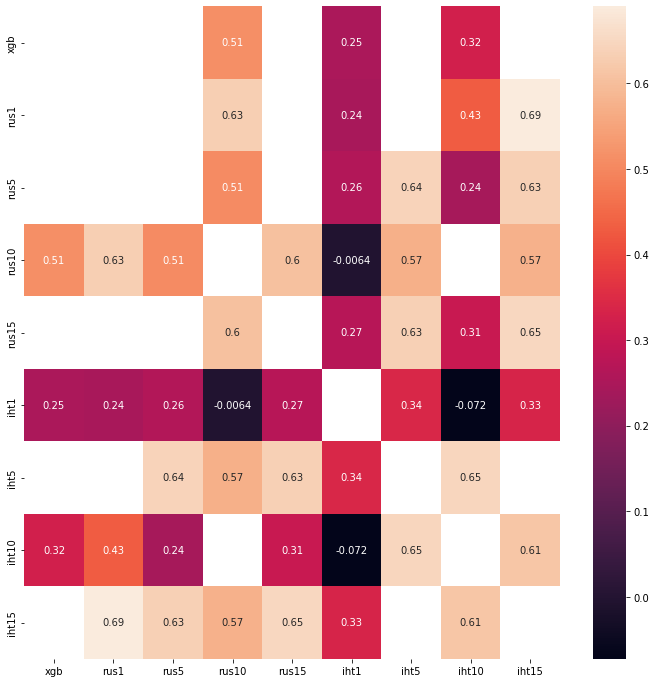

In [92]:
f,ax = plt.subplots(figsize=(12, 12))
snsfilter = sns.heatmap(pfi_importance.corr(method = 'spearman')[(pfi_importance.corr(method = 'spearman') <= 0.695)],
            annot=True);


### 6.2.3 PFI feature importance visualisation

In [93]:
#select top 10 features for original xgb
pfi_top10 = pfi_importance.sort_values(['xgb'], ascending=[False])
pfi_top10 = pfi_top10.head(10)
pfi_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
17,PAY_SEP,0.046,0.035,0.060,0.047,0.049,0.000,0.025,0.041,0.046
2,BILLAMT_SEP,0.016,0.010,0.021,0.011,0.009,0.010,0.015,0.011,0.015
0,LIMIT_BAL,0.015,0.024,0.021,0.009,0.013,0.000,0.005,0.001,0.006
9,PAYAMT_AUG,0.014,0.008,0.016,0.001,0.008,0.006,0.005,0.000,0.004
10,PAYAMT_JUL,0.012,0.023,0.019,0.015,0.007,0.002,0.006,0.005,0.007
8,PAYAMT_SEP,0.011,0.014,0.012,0.006,0.011,0.006,0.007,0.005,0.007
3,BILLAMT_AUG,0.011,0.012,0.011,0.005,0.009,0.014,0.008,0.004,0.008
11,PAYAMT_JUN,0.009,0.016,0.012,0.013,0.009,0.000,0.008,0.006,0.012
4,BILLAMT_JUL,0.009,0.005,0.012,0.006,0.010,0.033,0.005,0.000,0.006
18,PAY_AUG,0.008,0.018,0.007,0.015,0.006,0.051,0.013,0.015,0.011


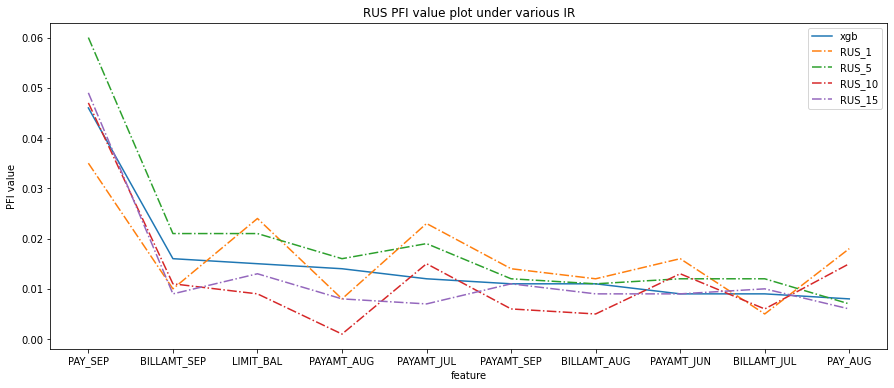

In [94]:
#1.aggeragate by approaches
#rus under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
rus_1 =pfi_top10['rus1'].tolist()
rus_5 =pfi_top10['rus5'].tolist()
rus_10 =pfi_top10['rus10'].tolist()
rus_15 =pfi_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('RUS PFI value plot under various IR')
plt.show()


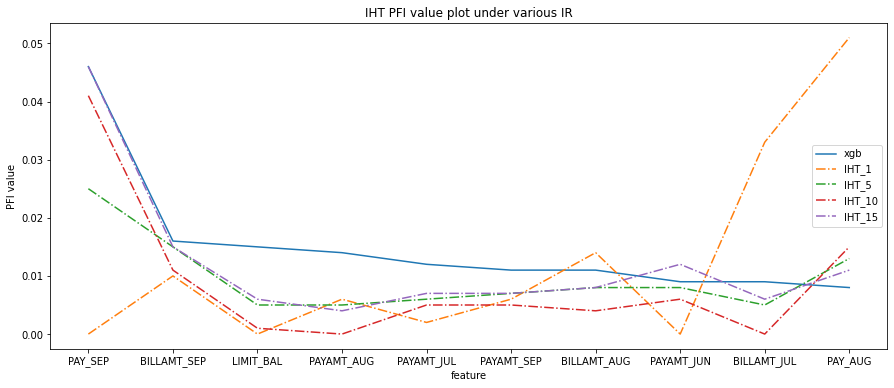

In [95]:
#iht under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
iht_1 =pfi_top10['iht1'].tolist()
iht_5 =pfi_top10['iht5'].tolist()
iht_10 =pfi_top10['iht10'].tolist()
iht_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('IHT PFI value plot under various IR')
plt.show()


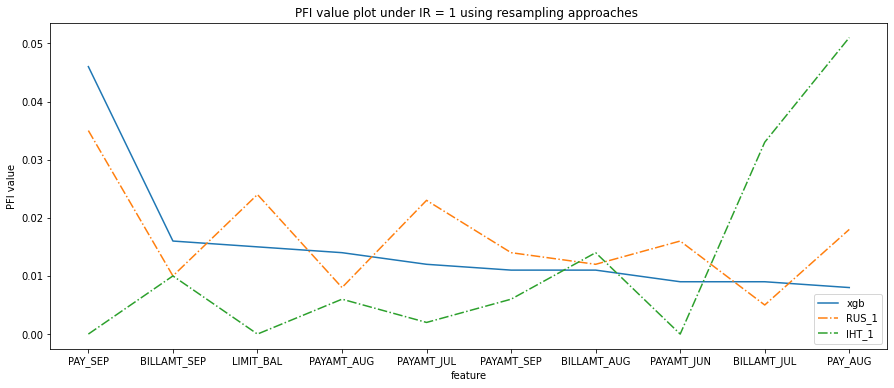

In [96]:
#aggeragate by ratio
#IR=1 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_1 =pfi_top10['rus1'].tolist()
IHT_1 =pfi_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 1 using resampling approaches ')
plt.show()


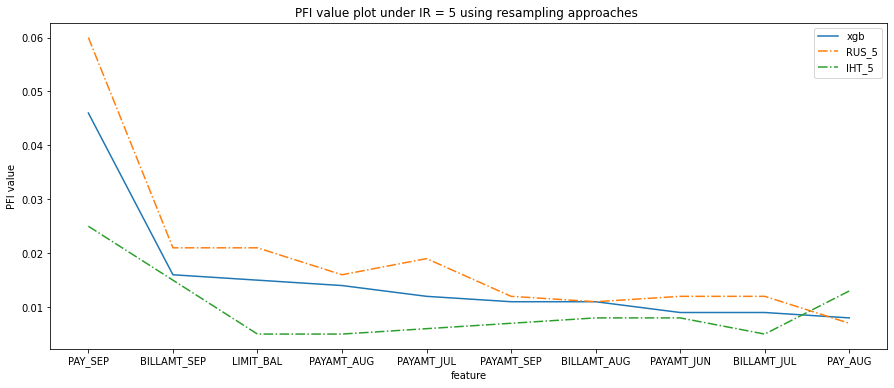

In [97]:
#IR=5 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_5 =pfi_top10['rus5'].tolist()
IHT_5 =pfi_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 5 using resampling approaches ')
plt.show()


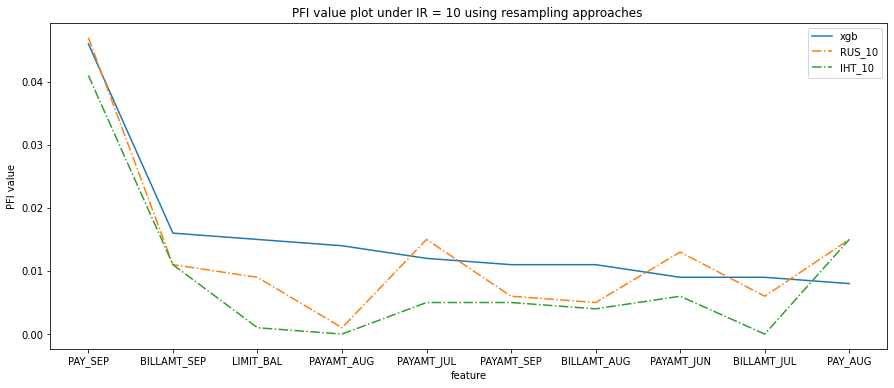

In [98]:
#IR=10 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_10 =pfi_top10['rus10'].tolist()
IHT_10 =pfi_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 10 using resampling approaches ')
plt.show()


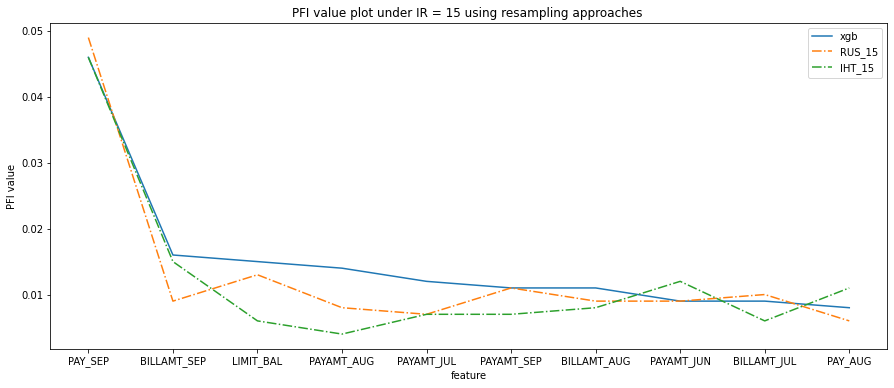

In [99]:
#IR=15 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_15 =pfi_top10['rus15'].tolist()
IHT_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 15 using resampling approaches ')
plt.show()
